In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

import glob
from IPython.display import display








from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-09 18:37:28.758956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 18:37:28.861674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 18:37:28.862419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [9]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [10]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [13]:
df_imgs = df[~df['path'].str.contains("mask")] # if have not mask
df_masks = df[df['path'].str.contains("mask")]# if have mask

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_13.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_13_mask.tif


In [14]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 4 columns]

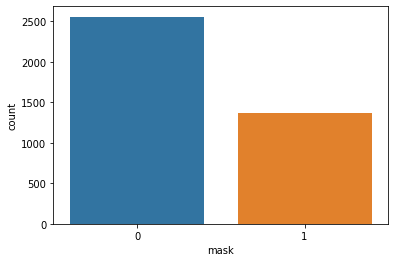

In [18]:
sns.countplot(brain_df['mask'])
plt.show()

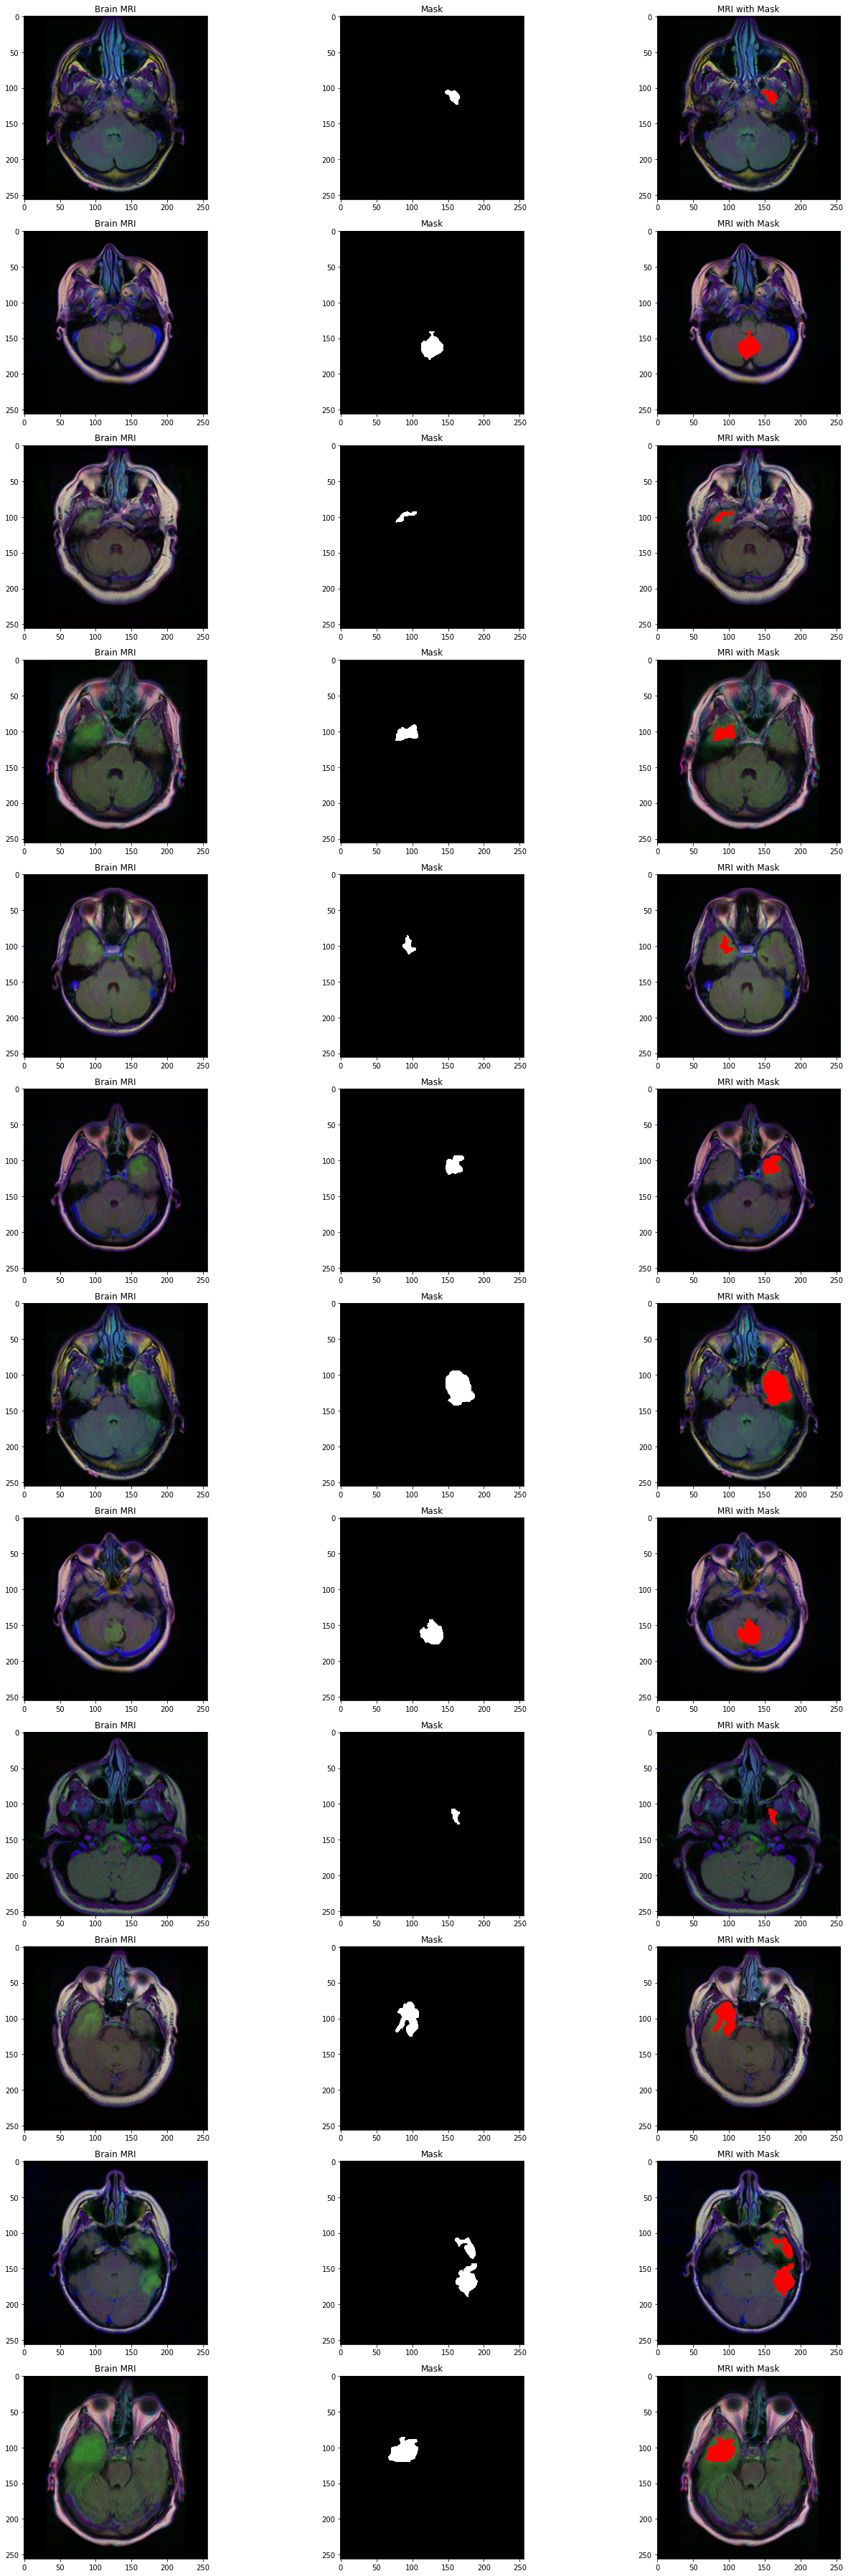

In [19]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

In [20]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [22]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [23]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

test_ids = list(X_test.image_path)
test_mask= list(X_test.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [24]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [25]:
test_data=DataGenerator(test_ids, test_mask)

In [36]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [37]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [38]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [39]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [40]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [41]:
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [42]:
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="segnet_100_epoch.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [46]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (256, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((256,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy,tversky])
    model.summary()
    hist = model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )
    
    model.save(savename)
    return model,hist

In [47]:
# Encoding layer
img_input = Input(shape= (256, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer 
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((256,256))(x)

In [48]:
model, hist = segnet(epochs_num= 60, savename= 'segnet_100_epoch.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 256, 256, 64)      256       
_________________________________________________________________
activation_234 (Activation)  (None, 256, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 256, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 256, 256, 64)      256       
_________________________________________________________________
activation_235 (Activation)  (None, 256, 256, 64)      0   

2022-06-09 18:56:03.552647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-06-09 18:56:07.434219: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 36s 355ms/step - loss: 0.6908 - iou: 0.6263 - dice_coef: 0.0612 - precision: 0.0470 - recall: 0.5434 - accuracy: 0.6377 - tversky: 0.0943 - val_loss: 0.5546 - val_iou: 0.6909 - val_dice_coef: 0.0654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.9647 - val_tversky: 0.0984

Epoch 00001: val_loss improved from inf to 0.55456, saving model to segnet_100_epoch.h5
Epoch 2/60
72/72 [==============================] - 24s 338ms/step - loss: 0.5354 - iou: 0.7023 - dice_coef: 0.0665 - precision: 0.1429 - recall: 0.3567 - accuracy: 0.9105 - tversky: 0.1013 - val_loss: 0.4561 - val_iou: 0.7506 - val_dice_coef: 0.0623 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.9657 - val_tversky: 0.0922

Epoch 00002: val_loss improved from 0.55456 to 0.45607, saving model to segnet_100_epoch.h5
Epoch 3/60
72/72 [==============================] - 24s 337ms/step - loss: 0.4317 - iou: 0.7672 - dice_coef: 0.0873 - precision: 0.

In [50]:
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy,tversky])

In [51]:
model_1.load_weights('segnet_100_epoch.h5')

In [55]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(train_data, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print('Tversky:   |   {:.2f}  |'.format(res[6]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(test_data, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print('Tversky:   |   {:.2f}  |'.format(res[6]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(val_data, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print('Tversky:   |   {:.2f}  |'.format(res[6]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

72/72 [==============================] - 8s 110ms/step - loss: 0.0596 - iou: 0.9853 - dice_coef: 0.4661 - precision: 0.8865 - recall: 0.8704 - accuracy: 0.9932 - tversky: 0.5626
________________________
IOU:       |   98.53  |
Dice Coef: |   46.61  |
Precision: |   88.65  |
Recall:    |   87.04  |
Accuracy:  |   99.32  |
Tversky:   |   56.26  |
Loss:      |   5.96  |
________________________

-------------On Test  Set--------------------------

6/6 [==============================] - 1s 246ms/step - loss: 0.0716 - iou: 0.9773 - dice_coef: 0.4262 - precision: 0.8563 - recall: 0.7044 - accuracy: 0.9874 - tversky: 0.5029
________________________
IOU:       |   97.73  |
Dice Coef: |   42.62  |
Precision: |   85.63  |
Recall:    |   70.44  |
Accuracy:  |   98.74  |
Tversky:   |   50.29  |
Loss:      |   7.16  |
________________________

-------------On validation Set----------------

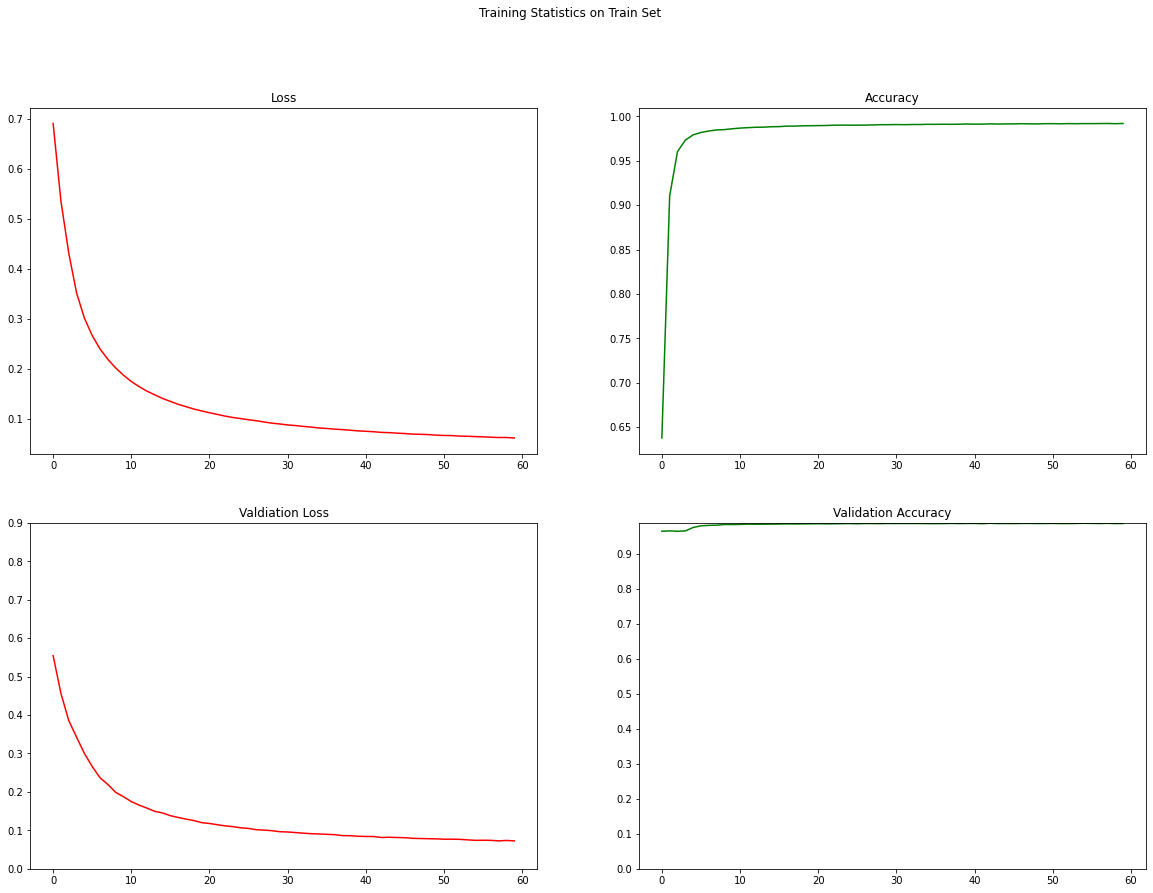

In [56]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

In [57]:
def prediction(test, model_seg):
  
    # empty list to store results
    mask, image_id,has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        

        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [58]:
df_pred = prediction(X_test, model)

In [59]:
df_pred = X_test.merge(df_pred, on='image_path')
df_pred.head(10)

patient_id                                         image_path  \
0  TCGA_DU_5852_19950709  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_HT_7605_19950916  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7019_19940908  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_HT_8114_19981030  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_CS_6290_20000917  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
5  TCGA_HT_7881_19981015  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
6  TCGA_DU_A5TT_19980318  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
7  TCGA_DU_7019_19940908  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
8  TCGA_DU_6407_19860514  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
9  TCGA_CS_6666_20011109  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  mask  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
5  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
6  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
7  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
8  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   
9  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     1   

                                      predicted_mask  has_mask  
0  [[[0.045882847, 0.04300026, 0.041577607, 0.040...         1  
1  [[[0.044982407, 0.04215864, 0.040566184, 0.040...         1  
2  [[[0.045815237, 0.04284205, 0.041630015, 0.041...         1  
3  [[[0.04592169, 0.044000927, 0.043862652, 0.042...         1  
4  [[[0.04512427, 0.04216654, 0.04235364, 0.04198...         1  
5  [[[0.04576032, 0.042785037, 0.043081786, 0.043...         1  
6  [[[0.04565016, 0.0426193, 0.041978706, 0.04197...         1  
7  [[[0.045496166, 0.041634966, 0.042130843, 0.04...         1  
8  [[[0.04568907, 0.042627, 0.04261111, 0.0422559...         1  
9  [[[0.045116205, 0.041817363, 0.041773118, 0.04...         1

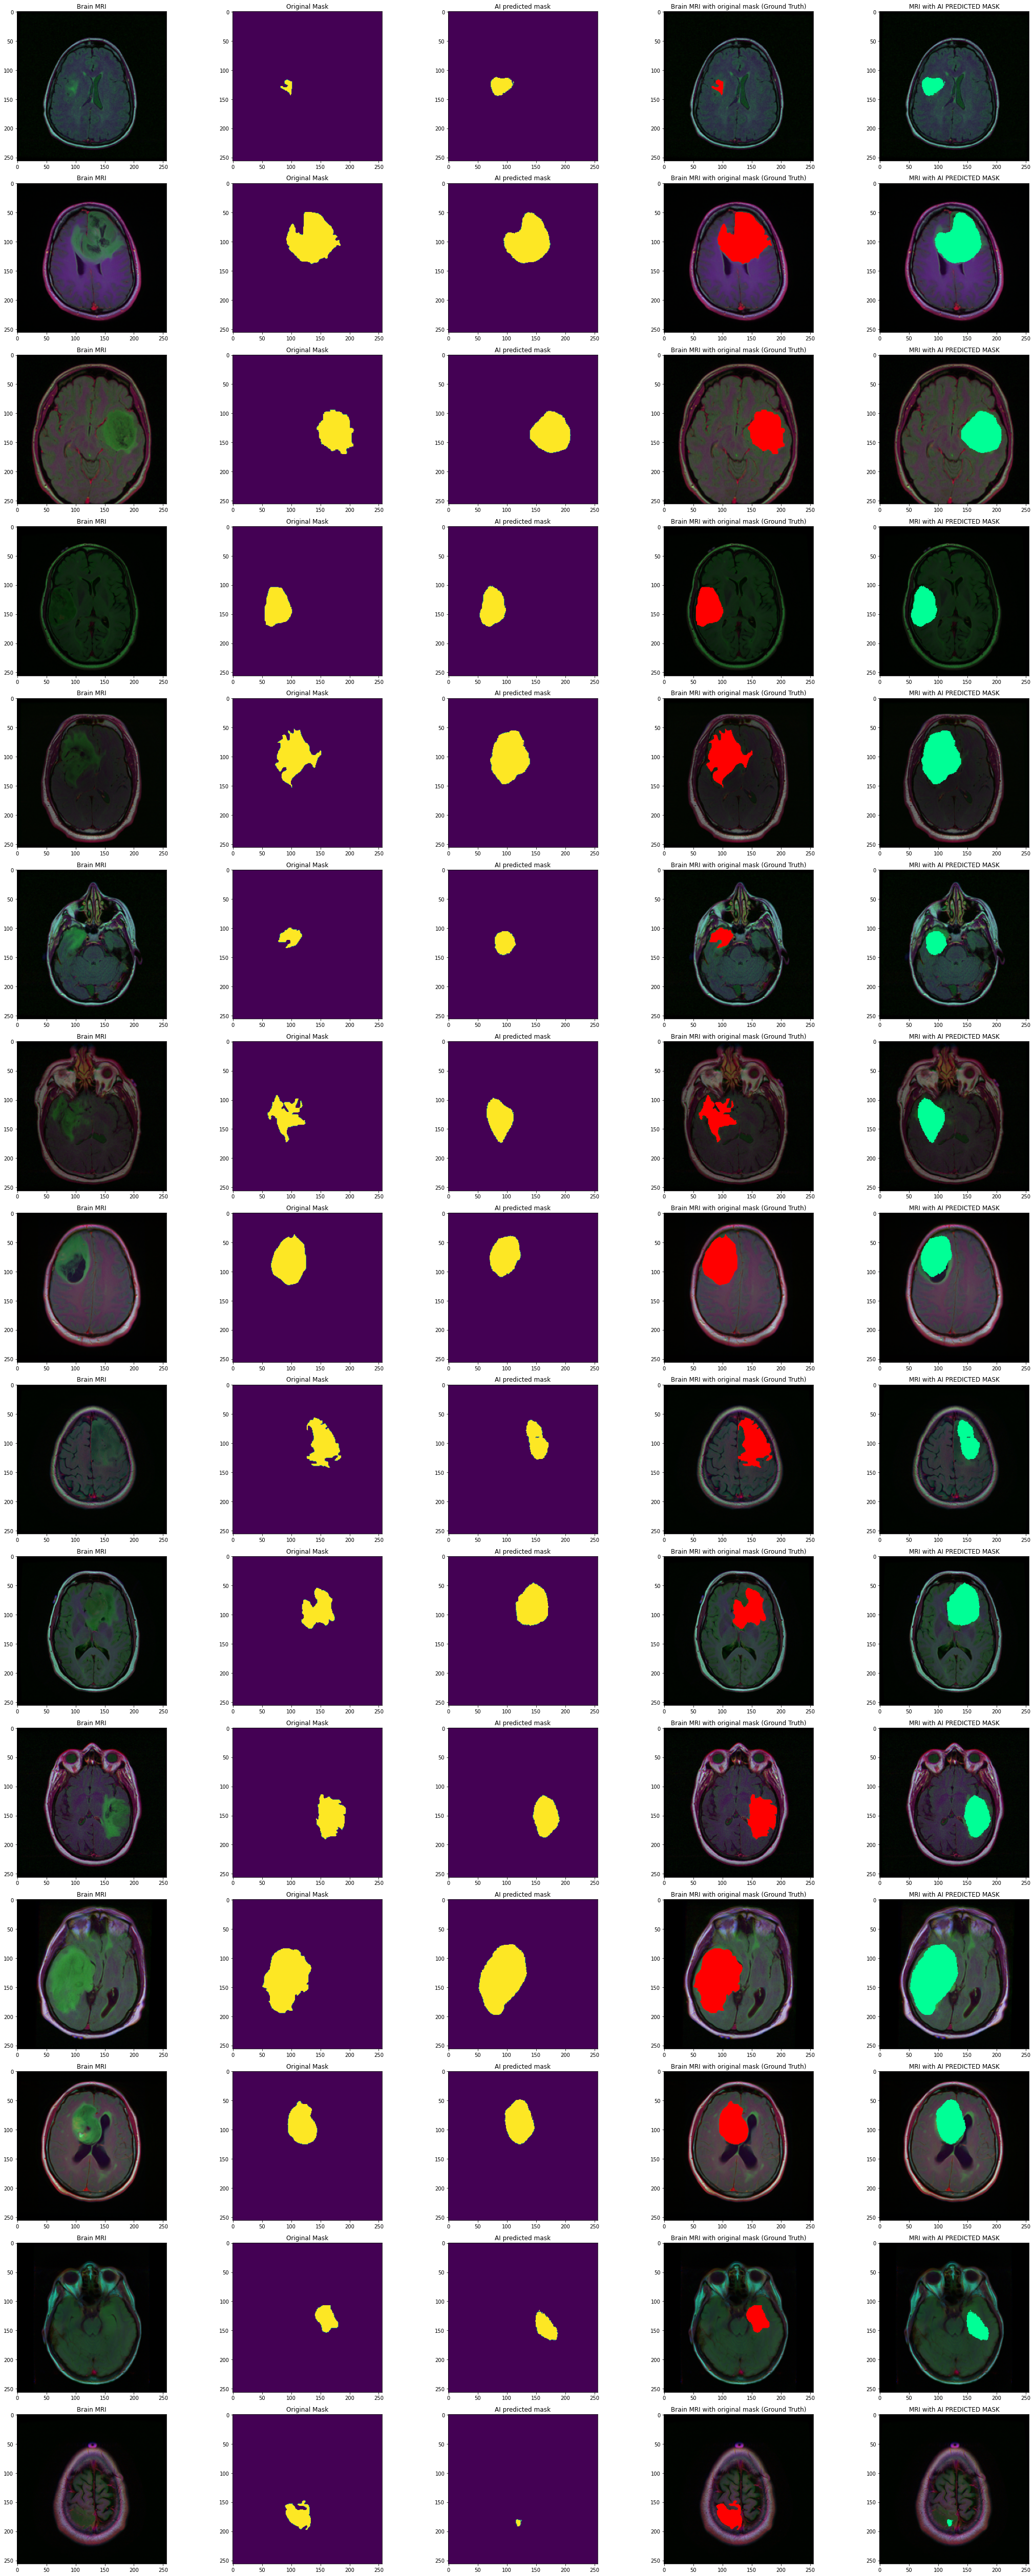

In [60]:
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        
